A Web API (Application Programming Interface) is a set of rules and protocols for building and interacting with software applications. A web API allows different software systems to communicate with each other over the internet using a set of defined operations. It enables services and products to exchange data and functionality easily and securely, often in the form of JSON or CSV data. 


In [2]:
# Import modules
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt

## Example 1: National Weather Service

The National Weather Service has a free [Application Programming Interface (API)](https://www.weather.gov/documentation/services-web-api) that we can use to request forecast and alert weather conditions. The API has several end points, in this example we will use the end point to retrieve weather forecasts based on geographic coordinates.

In [9]:
# Define location latitude and longitude
latitude = 37
longitude = -97

# Build API url
url = f"https://api.weather.gov/points/{latitude},{longitude}"

# Make the request
result = requests.get(url)


In [10]:
# Get the request output in Javascript Object Notation (JSON) format
output = result.json()
output['properties']['forecast']


'https://api.weather.gov/gridpoints/ICT/73,3/forecast'

In [11]:
# Request forecast for next seven days in 12-hour periods
forecast_url = output['properties']['forecast']
forecast = requests.get(forecast_url).json()


In [17]:
# Create dictionary to append variables of interest
data = {'start_time':[], 'temperature':[], 'sky_conditions':[]}

for day in forecast['properties']['periods']:
    data['start_time'].append(day['startTime'])
    data['temperature'].append(day['temperature'])
    data['sky_conditions'].append(day['shortForecast'])
    
# Convert lists to Pandas Dataframe
df = pd.DataFrame(data)
df['start_time'] = pd.to_datetime(df['start_time'])
df.head(3)

,start_time,temperature,sky_conditions
0,2024-02-19 10:00:00-06:00,58,Sunny
1,2024-02-19 18:00:00-06:00,34,Clear
2,2024-02-20 06:00:00-06:00,71,Sunny


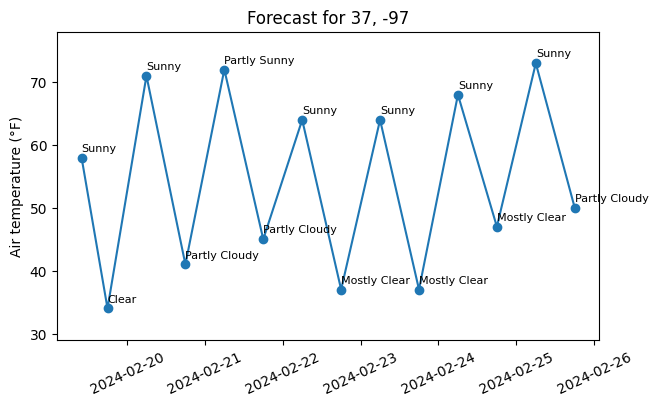

In [32]:
# Create a figure of the forecast
plt.figure(figsize=(7,4))
plt.title(f'Forecast for {latitude}, {longitude}')
plt.plot(df['start_time'], df['temperature'], '-o')
plt.ylabel(f'Air temperature ({chr(176)}F)')
plt.xticks(rotation=25)
plt.ylim([df['temperature'].min()-5, df['temperature'].max()+5])
for k,row in df.iterrows():
    plt.text(row['start_time'], row['temperature']+1, row['sky_conditions'], fontsize=8)
plt.show()

## Example 2: Kansas Mesonet

In this example we will learn to download data from the Kansas mesonet. Data can be accessed through a URL (Uniform Resource Locator), which is also known as a web address. In this URL we are going to pass some parameters to specify the location, date, and interval of the data. For services that output their data in comma-separated values we can use the Pandas library.

Kansas mesonet REST API: http://mesonet.k-state.edu/rest/

In [18]:
# Define function to request data
def get_ks_mesonet(station, start_date, end_date, variables, interval='day'):
    """
    Function to retrieve air temperature for a specific station 
    and period from the Kansas Mesonet
    
    Parameters
    ----------
    station : string
        Station name
    start_date : string
        yyyy-mm-dd format
    end_date : string
        yyyy-mm-dd fomat
    variables : list
        Weather variables to download
    interval : string
        One of the following: '5min', 'hour', or 'day'
        
    Returns
    -------
    df : Dataframe
        Table with data for specified station and period.
    
    """
    
    # Define date format as required by the API
    fmt = '%Y%m%d%H%M%S'
    start_date = pd.to_datetime(start_date).strftime(fmt)
    end_date = pd.to_datetime(end_date).strftime(fmt)
    
    # Concatenate variables using comma
    variables = ','.join(variables)
    
    # Create URL
    url = f"http://mesonet.k-state.edu/rest/stationdata/?stn={station}&int={interval}&t_start={start_date}&t_end={end_date}&vars={variables}"
    
    # A URL cannot have spaces, so we replace them with %20
    url = url.replace(" ", "%20")
    
    # Crete Dataframe and replace missing values by NaN
    df = pd.read_csv(url, na_values='M') # Request data and replace missing values represented by "M" for NaN values.
    
    return df


In [19]:
# Use function to request data
station = 'Manhattan'
start_date = '2024-01-01'
end_date = '2024-01-15'
variables = ['TEMP2MAVG','PRECIP']

df_ks_mesonet = get_ks_mesonet(station, start_date, end_date, variables)
df_ks_mesonet.head()


,TIMESTAMP,STATION,TEMP2MAVG,PRECIP
0,2024-01-01 00:00:00,Manhattan,-1.40,0.0
1,2024-01-02 00:00:00,Manhattan,-2.15,0.0
2,2024-01-03 00:00:00,Manhattan,-1.09,0.0
3,2024-01-04 00:00:00,Manhattan,-1.20,0.0
4,2024-01-05 00:00:00,Manhattan,-0.38,0.0


## Example 3: U.S. Geological Survey streamflow data

In [67]:
def get_usgs(station, start_date, end_date=None):
    """
    Function to retreive 15-minute streamflow data from the U.S. Geological Survey.
    
    Parameters
    ----------
    station : string
        8-digit number of the USGS streamflow gauge of interest
    start_date : string
        Start UTC date in yyyy-mm-dd HH:MM:SS format
    end_date : string (optional)
        End UTC date in yyyy-mm-dd HH:MM:SS format.
        If not provided, the dataset will span from start_date until present time

        
    Returns
    -------
    df : Dataframe
        Table with 15-minute streamflow data.
        'A' stands for active
        'P'  stands for "Provisional" data subject to revision.
        'datetime' is reported in local time (including standard and daylight time)
        'discharge' is in ft^3/s
        'height' is in ft
        
    API docs: https://waterservices.usgs.gov/docs/instantaneous-values/instantaneous-values-details/
    """

    # Check that station identifier has 8 digits
    if len(station) != 8:
        raise ValueError("Station must be an an 8-digit code")
            
    # Convert strings to UTC time using ISO format
    start_date = pd.to_datetime(start_date).isoformat() + 'Z'
    if end_date is not None:
        end_date = pd.to_datetime(end_date).isoformat() + 'Z'
        
        # Check that start date is smaller than end date
        if start_date > end_date:
            raise ValueError("start_date cannot be greater than end_date")

    
    # Build URL and define parameter values for request
    url = 'https://waterservices.usgs.gov/nwis/iv/'
    params = {'format': 'rdb', 
              'sites': '06879650', 
              'startDT': start_date,
              'endDT':end_date,
              'parameterCd': '00060,00065', # discharge and height
              'siteStatus':'active'}

    # Request data
    response = requests.get(url, params=params)
    s = response.content
    
    df = pd.read_csv(io.StringIO(s.decode('utf-8')), sep='\t', comment='#')
    if df.shape[0] == 0:
        raise IndexError("DataFrame is empty")
    
    df.drop([0], inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.rename(columns={"56608_00060": "discharge_ft3_s",
                       "56608_00060_cd": "status_discharge",
                       "56607_00065": "height_ft",
                       "56607_00065_cd": "status_height"}, inplace=True)

    # Convert dates to datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Convert discharge and height to float type
    df['discharge_ft3_s'] = df['discharge_ft3_s'].astype(float)
    df['height_ft'] = df['height_ft'].astype(float)
        
    return df
    

In [70]:
# Download data for the Kings Creek watershed within
# the Konza Prairie Biological Station near Manhattan, KS
station = '06879650' # Kings Creek watershed
start_date = '2023-04-15'
end_date = '2023-07-15'
df_usgs = get_usgs(station, start_date, end_date)


In [72]:
# Display downloaded data
df_usgs.head(3)


,agency_cd,site_no,datetime,tz_cd,discharge_ft3_s,status_discharge,height_ft,status_height
0,USGS,06879650,2023-04-14 18:00:00,CDT,0.0,A,2.5,A
1,USGS,06879650,2023-04-14 18:15:00,CDT,0.0,A,2.5,A
2,USGS,06879650,2023-04-14 18:30:00,CDT,0.0,A,2.5,A


In [73]:
# Convert discharge from ft^3/s to cubic m^3/s
df_usgs['discharge_m3_per_s'] = df_usgs['discharge_ft3_s']*0.0283168 

# Convert height from ft to m
df_usgs['height_m'] = df_usgs['height_ft']/0.3048

# Standardize all timestamps to UTC
idx_cdt = df_usgs['tz_cd'] == 'CDT'
df_usgs.loc[idx_cdt,'datetime'] = df_usgs.loc[idx_cdt,'datetime'] + pd.Timedelta('5H')

idx_cst = df_usgs['tz_cd'] == 'CST'
df_usgs.loc[idx_cst,'datetime'] = df_usgs.loc[idx_cst,'datetime'] + pd.Timedelta('6H')

# Replace label from CST/CDT to UTC
df_usgs['tz_cd'] = 'UTC'

# Check our changes
df_usgs.head(3)

# Save to drive
#filename = f"{station}_streamflow.csv"
#df.to_csv(filename, index=False)

,agency_cd,site_no,datetime,tz_cd,discharge_ft3_s,status_discharge,height_ft,status_height,discharge_m3_per_s,height_m
0,USGS,06879650,2023-04-14 23:00:00,UTC,0.0,A,2.5,A,0.0,8.2021
1,USGS,06879650,2023-04-14 23:15:00,UTC,0.0,A,2.5,A,0.0,8.2021
2,USGS,06879650,2023-04-14 23:30:00,UTC,0.0,A,2.5,A,0.0,8.2021


In [74]:
# Set 'datetime' column as timeindex
df_usgs.set_index('datetime', inplace=True)
df_usgs.head(3)


,agency_cd,site_no,tz_cd,discharge_ft3_s,status_discharge,height_ft,status_height,discharge_m3_per_s,height_m
datetime,,,,,,,,,
2023-04-14 23:00:00,USGS,06879650,UTC,0.0,A,2.5,A,0.0,8.2021
2023-04-14 23:15:00,USGS,06879650,UTC,0.0,A,2.5,A,0.0,8.2021
2023-04-14 23:30:00,USGS,06879650,UTC,0.0,A,2.5,A,0.0,8.2021


In [75]:
# Aggregate data hourly
df_usgs_daily = df_usgs.resample('1D').agg({'agency_cd':np.unique,
                                             'site_no':np.unique,
                                             'tz_cd':np.unique,
                                             'discharge_ft3_s':'mean',
                                             'status_discharge':np.unique,
                                             'height_ft':'mean',
                                             'status_height':np.unique,
                                             'discharge_m3_per_s':'mean',
                                             'height_m':'mean'})
df_usgs_daily.head(3)


,agency_cd,site_no,tz_cd,discharge_ft3_s,status_discharge,height_ft,status_height,discharge_m3_per_s,height_m
datetime,,,,,,,,,
2023-04-14,[USGS],[06879650],[UTC],0.0,[A],2.500000,[A],0.0,8.202100
2023-04-15,[USGS],[06879650],[UTC],0.0,[A],2.496667,[A],0.0,8.191164
2023-04-16,[USGS],[06879650],[UTC],0.0,[A],2.494792,[A],0.0,8.185012


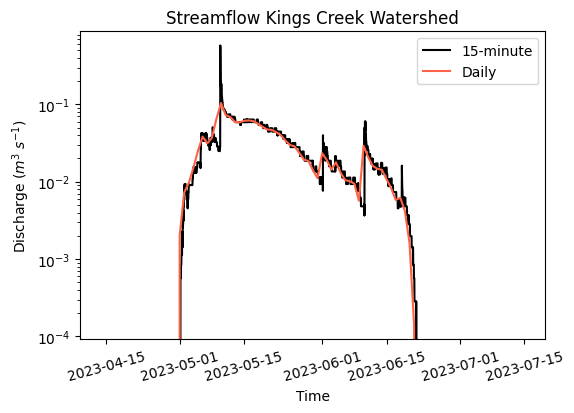

In [76]:
# Plot hydrograph
plt.figure(figsize=(6,4))
plt.title('Streamflow Kings Creek Watershed')
plt.plot(df_usgs['discharge_m3_per_s'], color='k', label='15-minute')
plt.plot(df_usgs_daily['discharge_m3_per_s'], color='tomato', label='Daily')
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Discharge ($m^3 \ s^{-1})$')
plt.xticks(rotation=15)
plt.legend()
plt.show()

## Example 4: U.S. Climate reference network

Example of retrieving data from the U.S. Climate reference Network

- Daily data: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/
- Daily data documentation: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/README.txt


In [10]:
def get_uscrn(station, year):
    """
    Function to retreive daily data from the U.S. Climate Reference Network.
    
    Parameters
    ----------
    station : string
        Station name
    year : integer
        Year for data request

        
    Returns
    -------
    df : Dataframe
        Table with daily data for an entire year for a given station
    """
    
    url = f'https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/{year}/{station}'
    daily_headers = ['WBANNO','LST_DATE','CRX_VN','LONGITUDE','LATITUDE',
                     'T_DAILY_MAX','T_DAILY_MIN','T_DAILY_MEAN','T_DAILY_AVG',
                     'P_DAILY_CALC','SOLARAD_DAILY','SUR_TEMP_DAILY_TYPE',
                     'SUR_TEMP_DAILY_MAX','SUR_TEMP_DAILY_MIN','SUR_TEMP_DAILY_AVG',
                     'RH_DAILY_MAX','RH_DAILY_MIN','RH_DAILY_AVG','SOIL_MOISTURE_5_DAILY',
                     'SOIL_MOISTURE_10_DAILY','SOIL_MOISTURE_20_DAILY','SOIL_MOISTURE_50_DAILY',
                     'SOIL_MOISTURE_100_DAILY','SOIL_TEMP_5_DAILY','SOIL_TEMP_10_DAILY',
                     'SOIL_TEMP_20_DAILY','SOIL_TEMP_50_DAILY','SOIL_TEMP_100_DAILY']       

    # Read fixed width data
    df = pd.read_fwf(url, names=daily_headers)

    # Convert date from string to datetime format
    df['LST_DATE'] = pd.to_datetime(df['LST_DATE'],format='%Y%m%d')

    # Replace missing values (-99 and -9999)
    df = df.replace([-99,-9999,999], np.nan)
    return df


In [14]:
# URL link and header variables
year = 2018
station = 'CRND0103-2018-KS_Manhattan_6_SSW.txt'

df_uscrn = get_uscrn(year, station)
df_uscrn.head()

,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,2018-01-01,2.422,-96.61,39.1,-11.0,-23.4,-17.2,-17.1,0.0,...,NaN,0.114,NaN,NaN,NaN,-2.7,-0.8,0.8,NaN,NaN
1,53974,2018-01-02,2.422,-96.61,39.1,-4.4,-20.8,-12.6,-11.6,0.0,...,NaN,0.106,NaN,NaN,NaN,-2.5,-1.0,0.1,NaN,NaN
2,53974,2018-01-03,2.422,-96.61,39.1,-1.5,-13.3,-7.4,-6.1,0.0,...,NaN,0.105,NaN,NaN,NaN,-1.8,-0.7,-0.1,NaN,NaN
3,53974,2018-01-04,2.422,-96.61,39.1,3.2,-16.3,-6.5,-6.5,0.0,...,NaN,0.102,NaN,NaN,NaN,-1.9,-0.8,-0.2,NaN,NaN
4,53974,2018-01-05,2.422,-96.61,39.1,-0.6,-11.9,-6.2,-6.7,0.0,...,NaN,0.102,NaN,NaN,NaN,-1.6,-0.6,-0.1,NaN,NaN
